In [1]:
%env ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
%env ARTS_DATA_PATH=/home/simon/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simon/build/arts_production/arts

from typhon.arts.workspace import Workspace

env: ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
env: ARTS_DATA_PATH=/home/simon/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simon/build/arts_production/arts
Loading ARTS API from: /home/simon/build/arts_production/arts/src/libarts_api.so


In [2]:
ws = Workspace()
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

ARTS[93951125121168]: Executing /home/simon/src/arts_clean/controlfiles/general/general.arts
ARTS[93951125121168]: {
ARTS[93951125121168]: - verbosityInit
ARTS[93951125121168]: - scat_speciesSet
ARTS[93951125121168]: - MatrixSet
ARTS[93951125121168]: - Tensor4SetConstant
ARTS[93951125121168]: - ArrayOfStringSet
ARTS[93951125121168]: - Touch
ARTS[93951125121168]: - FlagOff
ARTS[93951125121168]: - MatrixSet
ARTS[93951125121168]: - NumericSet
ARTS[93951125121168]: - ArrayOfStringSet
ARTS[93951125121168]: - Tensor3SetConstant
ARTS[93951125121168]: - Tensor3SetConstant
ARTS[93951125121168]: - Tensor3SetConstant
ARTS[93951125121168]: - Tensor3SetConstant
ARTS[93951125121168]: - Tensor3SetConstant
ARTS[93951125121168]: - Tensor3SetConstant
ARTS[93951125121168]: - IndexSet
ARTS[93951125121168]: - IndexSet
ARTS[93951125121168]: - IndexSet
ARTS[93951125121168]: - IndexSet
ARTS[93951125121168]: - FlagOff
ARTS[93951125121168]: - output_file_formatSetAscii
ARTS[93951125121168]: - StringSet
ARTS[939

In [3]:
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )

In [4]:
ws.stokes_dim = 1
ws.cloudboxOff()
ws.jacobianOff()

In [5]:
ws.VectorNLogSpace( ws.p_grid, 200, 1013e2, 10.0 )
ws.abs_speciesSet( species=["N2", "O2", "H2O"] )
# Read a line file and a matching small frequency grid
ws.abs_linesReadFromSplitArtscat(
    ws.abs_species,
    "spectroscopy/Perrin/",
    10e9,
    250e9
    )
# Sort the line file according to species
ws.abs_lines_per_speciesCreateFromLines()

In [6]:
from typhon.arts.workspace.variables import *

ws.VectorNLogSpace( ws.p_grid, 200, 1013e2, 10.0 )
# Atmospheric scenario
ws.AtmRawRead( basename="planets/Earth/Fascod/midlatitude-summer/midlatitude-summer" )

# Create a frequency grid
ws.VectorNLinSpace( f_grid, 1000, 10e+9, 250e+9 )
# No sensor properties
ws.sensorOff()
# We select here to use Planck brightness temperatures
ws.StringSet( iy_unit, "PlanckBT" )
# Extract optical depth as auxiliary variables
ws.ArrayOfStringSet( iy_aux_vars, [ "Optical depth"] )
# Create vector container for the optical depth
odepth = ws.VectorCreate()


In [7]:
import numpy as np
# Atmosphere and surface
ws.AtmosphereSet1D()
ws.AtmFieldsCalc()
ws.Extract( ws.z_surface, ws.z_field, 0 )
ws.Extract( ws.t_surface, ws.t_field, 0 )

# Definition of sensor position and line of sight (LOS)
ws.MatrixSet( ws.sensor_pos, np.array([[180.0]])) # 10e3 for sensor in z = 10 km
ws.MatrixSet( ws.sensor_los, np.array([[180.0]])) # zenith angle: 0 looking up, 180 looking nadir

# Perform RT calculations
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmfields_checkedCalc()
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()

## Surface Agendas

In [8]:
import numpy as np
from typhon.arts.workspace import arts_agenda

ws.NumericCreate("wind_speed")
ws.NumericCreate("wind_direction")
ws.VectorCreate("transmittance")
ws.wind_speed     = 0.0
ws.wind_direction = 0.0
ws.transmittance  = np.ones(ws.f_grid.value.shape)

@arts_agenda
def surface_fastem(ws):
    ws.Print("bla", 1)
    ws.specular_losCalc()
    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
    ws.surfaceFastem(wind_speed     = ws.wind_speed,
                     wind_direction = ws.wind_direction,
                     transmittance  = ws.transmittance)
    
@arts_agenda
def surface_tessem(ws):
    ws.specular_losCalc()
    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
    ws.surfaceTessem(wind_speed     = ws.wind_speed)

### Fastem Calculations

In [9]:
ws.Copy(ws.surface_rtprop_agenda, surface_fastem)
ws.yCalc()
y_fastem = np.copy(ws.y)

### Tessem Calculations

In [10]:
ws.TessemNNReadAscii(tessem_neth, "testdata/tessem_sav_net_H.txt")
ws.TessemNNReadAscii(tessem_netv, "testdata/tessem_sav_net_V.txt")

ws.Copy(ws.surface_rtprop_agenda, surface_tessem)
ws.yCalc()
y_tessem = np.copy(ws.y)

ARTS[93951125121168]: 10 // 0.345232 // 0.36925
ARTS[93951125121168]: 10.2402 // 0.346265 // 0.370143
ARTS[93951125121168]: 10.4805 // 0.347295 // 0.371035
ARTS[93951125121168]: 10.7207 // 0.348324 // 0.371924
ARTS[93951125121168]: 10.961 // 0.349351 // 0.372812
ARTS[93951125121168]: 11.2012 // 0.350377 // 0.373697
ARTS[93951125121168]: 11.4414 // 0.3514 // 0.37458
ARTS[93951125121168]: 11.6817 // 0.352422 // 0.375461
ARTS[93951125121168]: 11.9219 // 0.353442 // 0.37634
ARTS[93951125121168]: 12.1622 // 0.35446 // 0.377217
ARTS[93951125121168]: 12.4024 // 0.355476 // 0.378091
ARTS[93951125121168]: 12.6426 // 0.35649 // 0.378964
ARTS[93951125121168]: 12.8829 // 0.357503 // 0.379834
ARTS[93951125121168]: 13.1231 // 0.358513 // 0.380702
ARTS[93951125121168]: 13.3634 // 0.359522 // 0.381568
ARTS[93951125121168]: 13.6036 // 0.360529 // 0.382432
ARTS[93951125121168]: 13.8438 // 0.361534 // 0.383294
ARTS[93951125121168]: 14.0841 // 0.362537 // 0.384153
ARTS[93951125121168]: 14.3243 // 0.363538

## Results

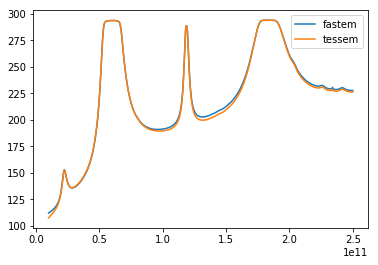

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ws.f_grid.value, y_fastem, label="fastem")
plt.plot(ws.f_grid.value, y_tessem, label="tessem")
plt.legend()

In [ ]:
plt.plot(ws.f_grid.value, y_fastem[0::2] - y_tessem[0::2])

In [ ]:
ws.Print("bla", 1)